In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy

In [2]:
tf_data=tf.keras.utils.image_dataset_from_directory('Indian Food/',batch_size=32,
                                                   shuffle=True,seed=123,
                                                    image_size=(256,256))

Found 789 files belonging to 3 classes.


In [5]:
classes=tf_data.class_names

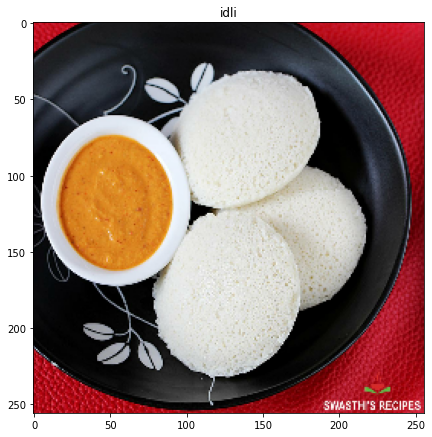

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,9))
for i,j in tf_data.take(1):
    plt.imshow(i[0].numpy().astype('uint8'))
    plt.title(classes[j[0]])
    break 

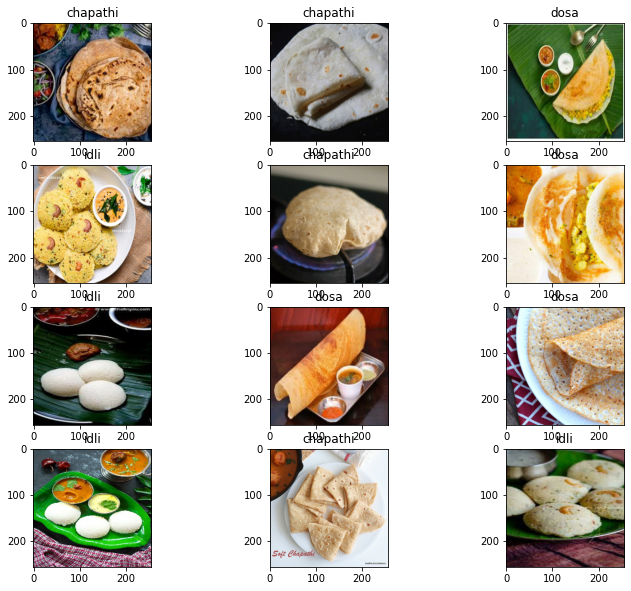

In [9]:
plt.figure(figsize=(12,10))
for i,j in tf_data.take(1):
    for y in range(0,12):
        plt.subplot(4,3,y+1)
        plt.imshow(i[y].numpy().astype('uint8'))
        plt.title(classes[j[y]])
    

In [8]:
tf_data=tf_data.shuffle(1000)

In [10]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical',
    seed=None),
    layers.experimental.preprocessing.RandomRotation(0.4)
])

In [12]:
def splitt(df):
    size=int(len(df)*0.8)
    train_df=df.take(size)
    test=df.skip(size)
    test_df=test.take(int(len(test)/2))
    val_df=test.skip(int(len(test)/2))
    return train_df,test_df,val_df

In [13]:
train_df,test_df,val_df=splitt(tf_data)
print(f"{len(train_df)}\n {len(test_df)}\n {len(val_df)}\n {len(tf_data)}\n")

20
 2
 3
 25



In [14]:
train_df=train_df.map(
    lambda x,y:(augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
train_df=train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df=test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df=val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
input_shape=(32,256,256,3)
n_classes=3
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.fit(train_df,
    batch_size=32,
    validation_data=val_df,
    verbose=1,
    epochs=25)

Epoch 1/25
20/20 [==============================] - 83s 3s/step - loss: 0.9702 - accuracy: 0.6137 - val_loss: 0.9795 - val_accuracy: 0.5765
Epoch 2/25
20/20 [==============================] - 56s 3s/step - loss: 0.8882 - accuracy: 0.6137 - val_loss: 0.8703 - val_accuracy: 0.5765
Epoch 3/25
20/20 [==============================] - 55s 3s/step - loss: 0.7961 - accuracy: 0.6455 - val_loss: 0.7521 - val_accuracy: 0.6235
Epoch 4/25
20/20 [==============================] - 53s 3s/step - loss: 0.7749 - accuracy: 0.6661 - val_loss: 0.8161 - val_accuracy: 0.5882
Epoch 5/25
20/20 [==============================] - 55s 3s/step - loss: 0.7412 - accuracy: 0.6741 - val_loss: 0.7280 - val_accuracy: 0.6706
Epoch 6/25
20/20 [==============================] - 54s 3s/step - loss: 0.7007 - accuracy: 0.6995 - val_loss: 0.7801 - val_accuracy: 0.6353
Epoch 7/25
20/20 [==============================] - 53s 3s/step - loss: 0.6769 - accuracy: 0.7075 - val_loss: 0.7463 - val_accuracy: 0.6588
Epoch 8/25
20/20 [==

first image to predict
actual label: idli
1/1 [==============================] - 1s 1s/step
predicted label: idli


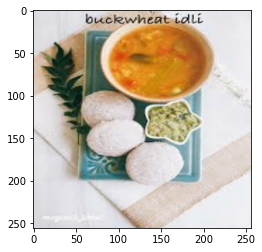

In [22]:
import numpy as np
for images_batch, labels_batch in test_df.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 109ms/step


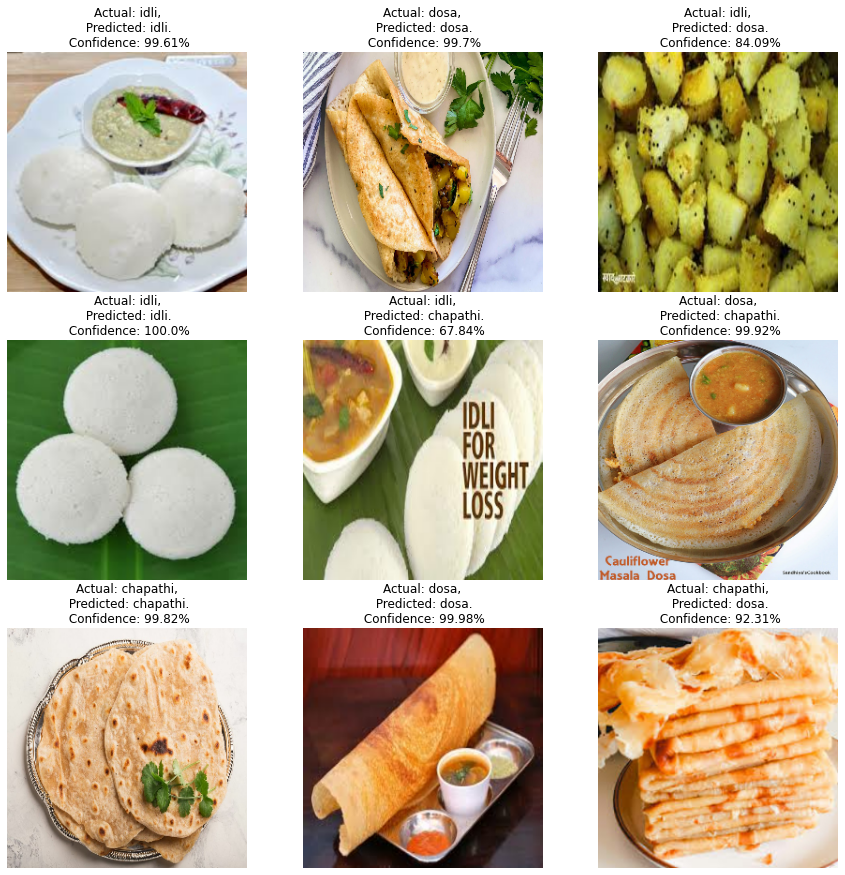

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
import os
model_version=max([int(i) for i in os.listdir("Models") + [0]])+1
model.save(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/1\assets


INFO:tensorflow:Assets written to: Models/1\assets


In [34]:
model.save("../model1.h5")